# Load Model Camembert pré-entrainé 

In [1]:
#!pip install sentencepiece
#!pip install transformers
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer    

# load model and tokenizer
nli_model = AutoModelForSequenceClassification.from_pretrained("BaptisteDoyen/camembert-base-xnli")
tokenizer = AutoTokenizer.from_pretrained("BaptisteDoyen/camembert-base-xnli") 
# sequences
premise = "le score pour les bleus est élevé"
hypothesis = "les bleu ont gagné"
# tokenize and run through model
x = tokenizer.encode(premise, hypothesis, return_tensors='pt')
logits = nli_model(x)[0]
logits

Downloading:   0%|          | 0.00/882 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

tensor([[ 1.3060,  0.5540, -2.1888]], grad_fn=<AddmmBackward0>)

# Résultat en probablité

In [2]:
entail_neutral_contradictio_logits = logits[:,::1]
probs = entail_neutral_contradictio_logits.softmax(dim=1)
probs

tensor([[0.6659, 0.3139, 0.0202]], grad_fn=<SoftmaxBackward0>)

rq: les probabilités sont ordonées comme suit: 
    **[entailment,neutral,contradiction]**

# Load données test

In [3]:
import pandas as pd
df = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")

In [4]:
#Je considère df_train comme étant données test à cause de faible de couple premise/hypothessis en français
df_test=pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv", sep=",")


In [5]:
 #Garder que le français
df_test=df_test[df_test["language"]=="French"]

#Garder que les columns dont on a besoin
df_test.drop(columns = ['id', 'lang_abv','language'],axis = 1, inplace = True)

#On renomme
df_test.rename(columns = {'premise':'sentence1', 'hypothesis':'sentence2','goldlabel':'gold_label'}, inplace = True)


In [6]:
df_test.groupby('label').count()

,sentence1,sentence2
label,,
0,133,133
1,129,129
2,128,128


In [7]:
df_test

,sentence1,sentence2,label
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,0
41,regarder une fille dans un parka en fourrure b...,La fille est habillée tout en rouge.,2
60,"Correctement mise en œuvre, cette approche fou...",L'approche vous montre le voyage qui a eu lieu.,0
69,La complexité du subjonctif en français ne le ...,Il n'essaie pas parce qu'il n'a aucune motivat...,1
70,La Maison Blanche va-t-elle se raviser ?,La Maison-Blanche changera-t-elle d'avis ?,0
...,...,...,...
12006,"Ouais, eh bien, le mec est là.",Le type est arrivé il y a deux minutes.,1
12027,Cela fait 17 ans que je suis affilié à l'IRT.,Je n'ai rien à voir avec l'IRT.,2
12064,"Ces travailleurs n'étaient pas bloqués, mais c...",Tous les occupants des étages supérieurs sont ...,2
12099,Mais mon travail était de mettre des parachute...,Je n'avais pas de travail alors j'ai gardé tou...,2


# Tester le modèle

In [9]:
#Ordre de des probabilités qui represente le Output de modèle
label_mapping = ['entailment', 'neutral', 'contradiction']

In [10]:
#récuperer les premisses et hypothèses
premise  = df_test['sentence1'].values
hypothesis = df_test['sentence2'].values


In [12]:
!pip install pretty_confusion_matrix
import torch
from torch import tensor
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, balanced_accuracy_score \
                            ,matthews_corrcoef, average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyflakes
    

In [13]:
#Récupération des probabilité de prediction de modèle par l'ordre définis auparavant
listt = []

for i in range (len(hypothesis)):
  x = tokenizer.encode(premise[i], hypothesis[i], return_tensors='pt')
  logits = nli_model(x)[0]
  logits = logits.detach().numpy()
  labels = [label_mapping[score_max] for score_max in logits.argmax(axis=1)]
  listt.append(labels)

In [39]:
listt

[['entailment'],
 ['contradiction'],
 ['entailment'],
 ['neutral'],
 ['entailment'],
 ['neutral'],
 ['entailment'],
 ['neutral'],
 ['contradiction'],
 ['entailment'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['contradiction'],
 ['entailment'],
 ['contradiction'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['entailment'],
 ['neutral'],
 ['entailment'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['contradiction'],
 ['contradiction'],
 ['contradiction'],
 ['neutral'],
 ['entailment'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['entailment'],
 ['entailment'],
 ['entailment'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['entailment'],
 ['contradiction'],
 ['neutral'],
 ['contradiction'],
 ['contradiction'],
 ['neutral'],
 ['entailment'],
 ['contradiction'],
 ['contradiction'],
 ['entailment'],
 ['neutral'],
 ['entailment'],
 ['contradiction

In [14]:
#Convertir la listt des prédictions en format prédifinit dans les données tests: 0 for entailment, 1 for neutral, 2 for contradiction
listt = [[0] if x == ['entailment'] else [1] if x == ['neutral'] else [2] for x in listt]
listt = np.array(listt)
listt = np.array(listt).reshape(-1)
listt

array([0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0,
       1, 0, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 2, 1,
       2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0,
       0, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2,
       1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0,
       2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 0,
       1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1,
       2, 2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0,
       1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1,
       2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 1, 1,
       0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2,

In [15]:
#transformer les données afin de calculer l'accuracy et la matrice de confusion 
le = LabelEncoder()
Y_test = np_utils.to_categorical(le.fit_transform(df_test["label"].values)).astype("int64")

In [16]:
Y_test

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [18]:
Y_predi = np_utils.to_categorical(le.fit_transform(listt)).astype("int64")

In [44]:
Y_predi

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [19]:
#Résultat accuracy
test_acc = (np.argmax(Y_predi, axis=1) == np.argmax(Y_test, axis=1)).sum()/Y_test.shape[0] * 100
print("Accuracy on test set is: "+str(test_acc),"%")

Accuracy on test set is: 83.33333333333334 %


In [47]:
df = pd.DataFrame({'set':['test'], 'accuracy':[test_acc]})
df

,set,accuracy
0,test,83.333333


In [20]:
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1),(np.argmax(Y_predi, axis=1)))

In [21]:
Y_test = np.argmax(Y_test, axis=1)
Y_predi = np.argmax(Y_predi, axis=1)

In [27]:
#la matrice de confusion affichage des labels [entailement, neutral, contradiction]
pp_matrix_from_data((Y_test), (Y_predi), labels=[0,1,2], title="Confusion Matrix")



TypeError: pp_matrix_from_data() got an unexpected keyword argument 'labels'

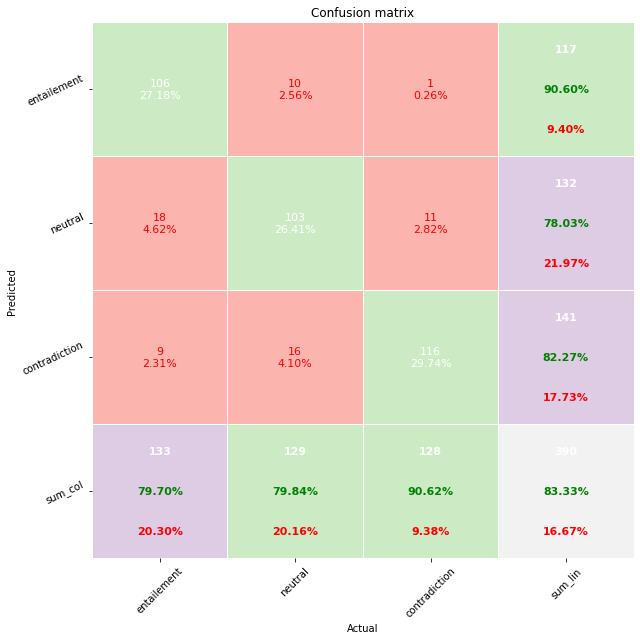

In [33]:
pp_matrix_from_data(Y_test, Y_predi, cmap='Pastel1',columns=['entailement','neutral','contradiction'],figsize=[8,8])
plot_co